In [16]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add the project root to system path
sys.path.append(os.path.abspath('..')) 

# Configuration
# CHANGED: We now use the optimized Parquet file instead of the massive CSV
RAW_DATA_PATH = "../data/raw/complaint_embeddings-001.parquet" 
PROCESSED_DATA_PATH = "../data/processed/filtered_complaints.csv"

In [19]:
print(f"Loading data from: {RAW_DATA_PATH}")

if not os.path.exists(RAW_DATA_PATH):
    print(f"❌ Error: File not found at {RAW_DATA_PATH}")
else:
    try:
        # 1. Load 'document' (text) and 'metadata' (struct)
        # We don't load 'embedding' to save RAM
        df_raw = pd.read_parquet(RAW_DATA_PATH, columns=['document', 'metadata'])
        
        # 2. Extract fields from the metadata dictionary
        print("Extracting metadata fields...")
        
        # The metadata column contains dictionaries. We extract keys into new columns.
        # using a vectorized approach for speed/memory efficiency
        meta_df = pd.json_normalize(df_raw['metadata'])
        
        # Select only what we need to save memory
        df_raw['product'] = meta_df['product']
        df_raw['issue'] = meta_df['issue']
        df_raw['company'] = meta_df['company']
        
        # Rename document to cleaned_narrative
        df_raw = df_raw.rename(columns={'document': 'cleaned_narrative'})
        
        # Drop the original metadata object to free RAM
        df_raw = df_raw.drop(columns=['metadata'])
        
        print(f"✅ Successfully loaded {len(df_raw):,} rows.")
        display(df_raw.head(3))
        
    except Exception as e:
        print(f"❌ Error loading parquet: {e}")

Loading data from: ../data/raw/complaint_embeddings-001.parquet
Extracting metadata fields...
✅ Successfully loaded 1,375,327 rows.


,cleaned_narrative,product,issue,company
0,a card was opened under my name by a fraudster...,Credit card,Getting a credit card,"CITIBANK, N.A."
1,i made the mistake of using my wellsfargo debi...,Checking or savings account,Managing an account,WELLS FARGO & COMPANY
2,and got a letter stating my dispute was reject...,Checking or savings account,Managing an account,WELLS FARGO & COMPANY


C:\Users\DELL 7020\AppData\Local\Temp\ipykernel_21372\406313299.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


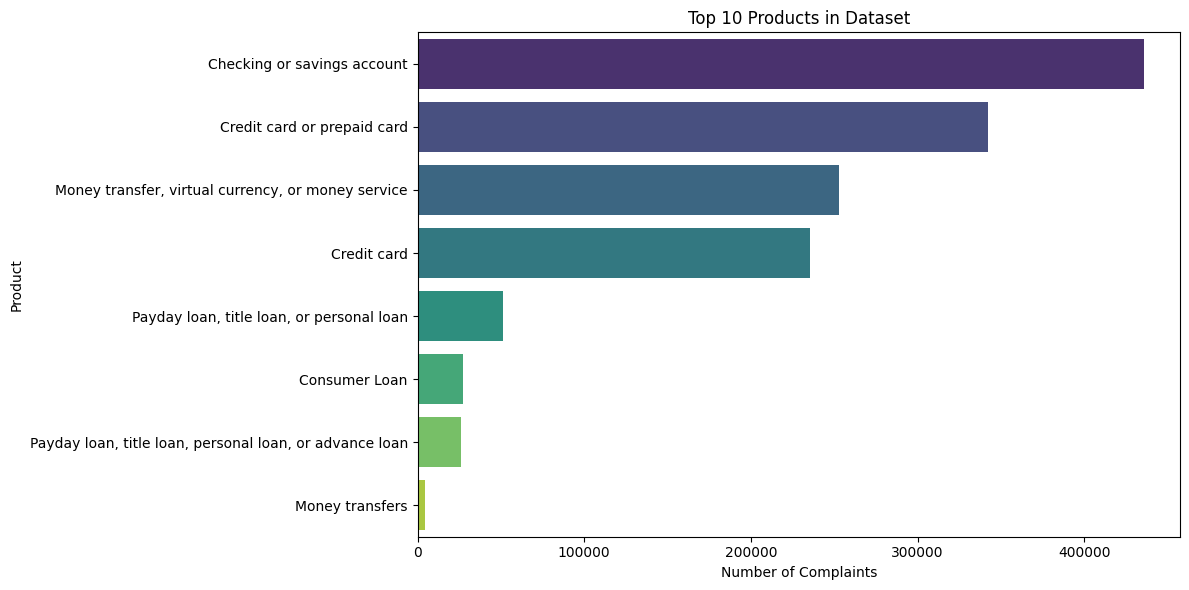

Rows with null text: 0
Rows with empty text: 0


In [21]:
if 'df_raw' in locals():
    plt.figure(figsize=(12, 6))
    
    # Get top 10 products
    top_products = df_raw['product'].value_counts().head(10)
    
    sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
    plt.title("Top 10 Products in Dataset")
    plt.xlabel("Number of Complaints")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

    # Check for empty narratives
    missing = df_raw['cleaned_narrative'].isnull().sum()
    empty = (df_raw['cleaned_narrative'] == '').sum()
    print(f"Rows with null text: {missing}")
    print(f"Rows with empty text: {empty}")
else:
    print("Data not loaded.")

In [22]:
# Standardize product names to match business requirements
TARGET_PRODUCTS = {
    "Credit card": "Credit Card",
    "Credit card or prepaid card": "Credit Card",
    "Prepaid card": "Credit Card",
    "Payday loan, title loan, or personal loan": "Personal Loan",
    "Consumer Loan": "Personal Loan",
    "Payday loan": "Personal Loan",
    "Checking or savings account": "Savings Account",
    "Bank account or service": "Savings Account",
    "Money transfer, virtual currency, or money service": "Money Transfer",
    "Money transfers": "Money Transfer"
}

if 'df_raw' in locals():
    print("Filtering and mapping product categories...")
    
    # 1. Filter rows where product matches our targets
    df_clean = df_raw[df_raw['product'].isin(TARGET_PRODUCTS.keys())].copy()
    
    # 2. Create the standardized 'product_category' column
    df_clean['product_category'] = df_clean['product'].map(TARGET_PRODUCTS)
    
    # 3. Calculate word count
    # Ensure text is string and handle potential Nones
    df_clean['cleaned_narrative'] = df_clean['cleaned_narrative'].fillna('').astype(str)
    df_clean['word_count'] = df_clean['cleaned_narrative'].apply(lambda x: len(x.split()))
    
    # 4. Filter short complaints
    df_clean = df_clean[df_clean['word_count'] >= 5]
    
    print(f"Filtered dataset size: {len(df_clean):,} rows")
    display(df_clean.head(3))

Filtering and mapping product categories...
Filtered dataset size: 1,335,336 rows


,cleaned_narrative,product,issue,company,product_category,word_count
0,a card was opened under my name by a fraudster...,Credit card,Getting a credit card,"CITIBANK, N.A.",Credit Card,82
1,i made the mistake of using my wellsfargo debi...,Checking or savings account,Managing an account,WELLS FARGO & COMPANY,Savings Account,93
2,and got a letter stating my dispute was reject...,Checking or savings account,Managing an account,WELLS FARGO & COMPANY,Savings Account,21


C:\Users\DELL 7020\AppData\Local\Temp\ipykernel_21372\2557359834.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product_category', data=df_clean, order=order, palette="pastel")


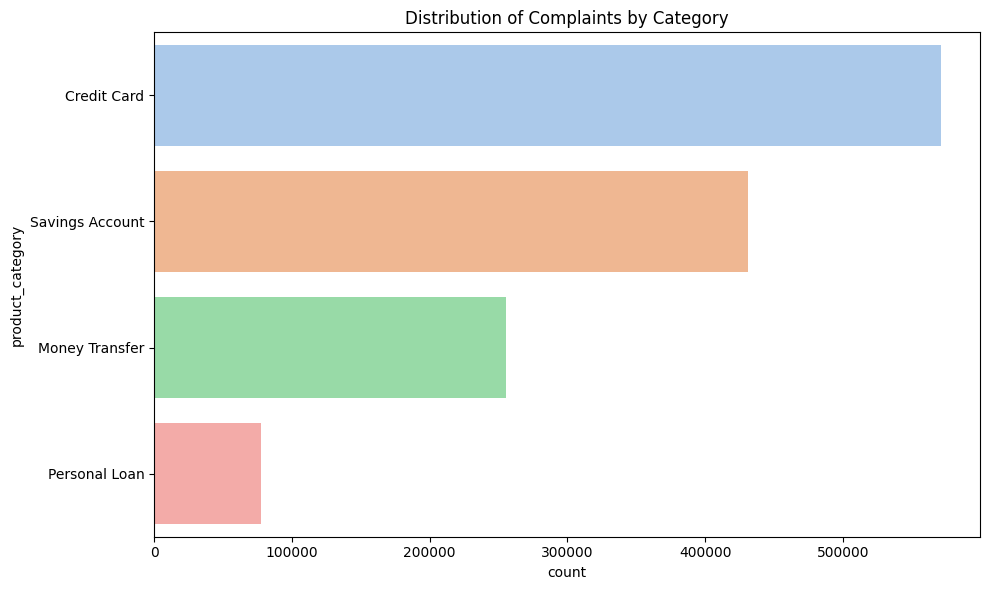

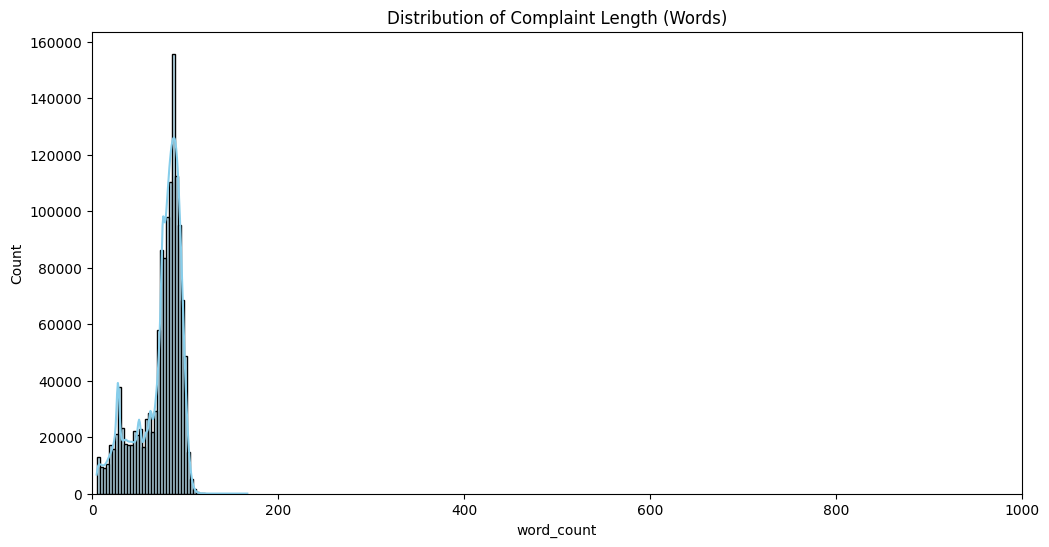

count    1.335336e+06
mean     7.291666e+01
std      2.382858e+01
min      5.000000e+00
25%      6.300000e+01
50%      8.100000e+01
75%      9.000000e+01
max      1.670000e+02
Name: word_count, dtype: float64


In [23]:
if 'df_clean' in locals():
    # 1. Product Distribution
    plt.figure(figsize=(10, 6))
    order = df_clean['product_category'].value_counts().index
    sns.countplot(y='product_category', data=df_clean, order=order, palette="pastel")
    plt.title("Distribution of Complaints by Category")
    plt.tight_layout()
    plt.show()

    # 2. Word Count Analysis
    plt.figure(figsize=(12, 6))
    sns.histplot(df_clean['word_count'], bins=50, kde=True, color='skyblue')
    plt.title("Distribution of Complaint Length (Words)")
    plt.xlim(0, 1000)
    plt.show()
    
    print(df_clean['word_count'].describe())

In [24]:
if 'df_clean' in locals():
    # Ensure directory exists
    os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)

    # Save to CSV (needed for Task 2 if you were re-running it, though you already have vectors)
    # We limit this to 20k rows to keep it light for the repo and local use
    df_export = df_clean.head(20000)
    
    df_export.to_csv(PROCESSED_DATA_PATH, index=False)
    print(f"✅ Saved clean CSV sample to: {os.path.abspath(PROCESSED_DATA_PATH)}")

✅ Saved clean CSV sample to: d:\10academy\phase5\rag-complaint-chatbot\data\processed\filtered_complaints.csv
